# Experimenting with cumulative pointclouds
## Install 
Don't forget to load the virtual env:
```
source scripts/ti_mmwave/bin/activate
sudo apt install ros-$ROS_DISTRO-ros-numpy

```

In [1]:
%matplotlib widget

from datetime import datetime, timedelta
import os
import copy

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
from scipy.spatial.transform import Rotation as R
import open3d as o3d


import rosbag
from rospy import Time
import ros_numpy


tranform_topic = "/mmwave/vrpn_client/estimated_transform"
pcl_topic = "/mmwave/vrpn_client/estimated_transform"

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
#load bag
bag_path = "../data/reconstruction_set_2022-10-06-18-05-03.bag"
bag = rosbag.Bag(bag_path)

Reading topic: /mmwave/ti_mmwave/radar_scan_pcl


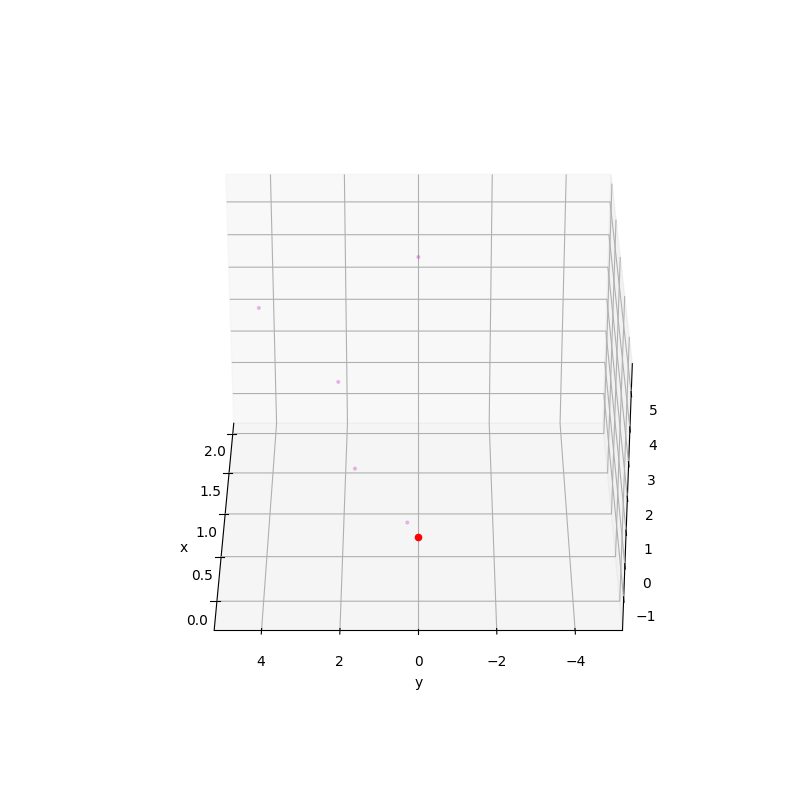

In [9]:
class PCL:
    def __init__(self, data, time = None, process = True):
        self.stamp = time
        self.data = data # expects ros msg pointcloud2
        self.points = [] # filled np array of shape (n,3,1)
        self.ranges = []
        
        if process:
            self.process_points()
        else:
            self.points = data
            
    def process_points(self):
        for line in self.data:
            point = np.asarray(line[:3])
            point = np.reshape(point, (3,1))
            self.points.append(point)
            self.ranges.append(np.linalg.norm(point))
            
            
    def compute_ranges(self):
        self.ranges = []
        for point in self.points:
            self.ranges.append(np.linalg.norm(point))
            
        
def read_pcl_topic(bag, topic):
    print('Reading topic: '+ topic)
    pcl_list = []

    try:
        msg_type = bag.get_type_and_topic_info()[1][topic][0]
    except KeyError:
        print("Oops!  Topic not found, skipping...")
        msg_type = "not_found_in_bag"
        return 
    counter = 0
    for topic, msg, t in bag.read_messages(topics=[topic]):
        time = np.datetime64(msg.header.stamp.secs, 's')+np.timedelta64(msg.header.stamp.nsecs, 'ns')
        
        points = []
        for local_points in ros_numpy.point_cloud2.pointcloud2_to_array(msg):
            points.append(list(local_points))
        points = np.asarray(points)
        #print("Found ", len(points), "points at seq ", counter)
        pcl_list.append(PCL(points, time = time))
        counter = counter + 1
        
    return pcl_list

pcls = read_pcl_topic(bag, '/mmwave/ti_mmwave/radar_scan_pcl')

def plot_pointcloud(pcl, x_lim = None, y_lim = None, c = None, alpha = 1):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    num_points = len(pcl.points)
    # this list messes up!!
    if isinstance(pcl.points, list):
        extracted_points = np.asarray(pcl.points).reshape((3,num_points))
    elif isinstance(pcl.points, np.ndarray):
         extracted_points = [pcl.points[:,0,0],
                             pcl.points[:,1,0],
                             pcl.points[:,2,0]]
        
    ax.scatter(extracted_points[0], extracted_points[1], extracted_points[2], c= c, s = 4, alpha = alpha)
    ax.scatter([0], [0],[0], c='r', label = "Sensor origin")

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    if x_lim is not None:
        ax.axes.set_xlim3d(bottom=x_lim[0], top=x_lim[1])
    if y_lim is not None:
        ax.axes.set_ylim3d(bottom=y_lim[0], top=y_lim[1])
        
    ax.azim = -180
    
    return fig, ax

plot_pointcloud(pcls[1], y_lim = (-5,5), c='m', alpha = 0.2)
plt.show()

In [10]:
class TF_stamped():
    def __init__(self, transl, quat, stamp = None):
        self.stamp = stamp
        self.t = np.asarray([[transl.x, transl.y, transl.z]]).T
        self.quat = quat
        
        self.rot_matrix = None
        
        self.generateRotMat()
        
    def generateRotMat(self):
        self.rot_matrix = R.from_quat([self.quat.x, self.quat.y, self.quat.z, self.quat.w])
        
    def transformPoint(self, point):
        #print(self.rot_matrix.as_matrix(), "\n", self.t)
        return np.dot(self.rot_matrix.as_matrix(), point) + self.t

def read_tf_topic(bag, topic):
    print('Reading topic: '+ topic)
    data = []

    try:
        msg_type = bag.get_type_and_topic_info()[1][topic][0]
    except KeyError:
        print("Oops!  Topic not found, skipping...")
        msg_type = "not_found_in_bag"

    for topic, msg, t in bag.read_messages(topics=[topic]):
        time = np.datetime64(msg.header.stamp.secs, 's')+np.timedelta64(msg.header.stamp.nsecs, 'ns')
        
        tf = TF_stamped(msg.transform.translation, msg.transform.rotation, time)
        
        data.append(tf)
    return data

tfs = read_tf_topic(bag, '/mmwave/vrpn_client/estimated_transform')

Reading topic: /mmwave/vrpn_client/estimated_transform


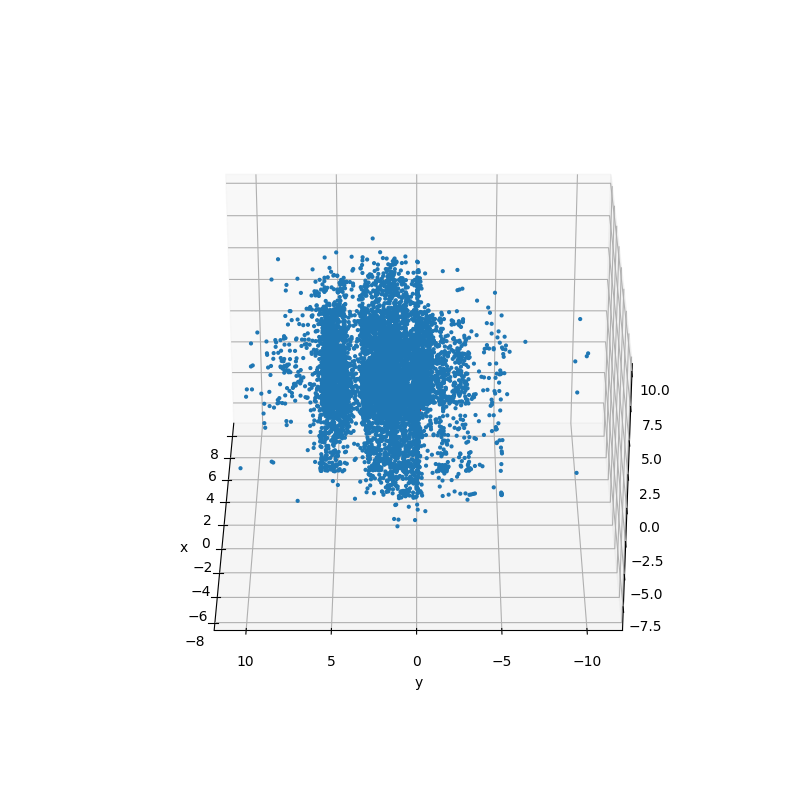

In [11]:
# append matches with transform
stamps = [tf.stamp for tf in tfs]

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

pcl_final = PCL([], process = False)
for pcl in pcls:
    index = find_nearest(pcl.stamp, stamps)
    stamp_diff = pcl.stamp - tfs[index].stamp
    
    best_tf = tfs[index]
    for point in pcl.points:
        point_registered = best_tf.transformPoint(point)
        pcl_final.points.append(point_registered)
    #break
plt.close('all')

_, ax = plot_pointcloud(pcl_final)


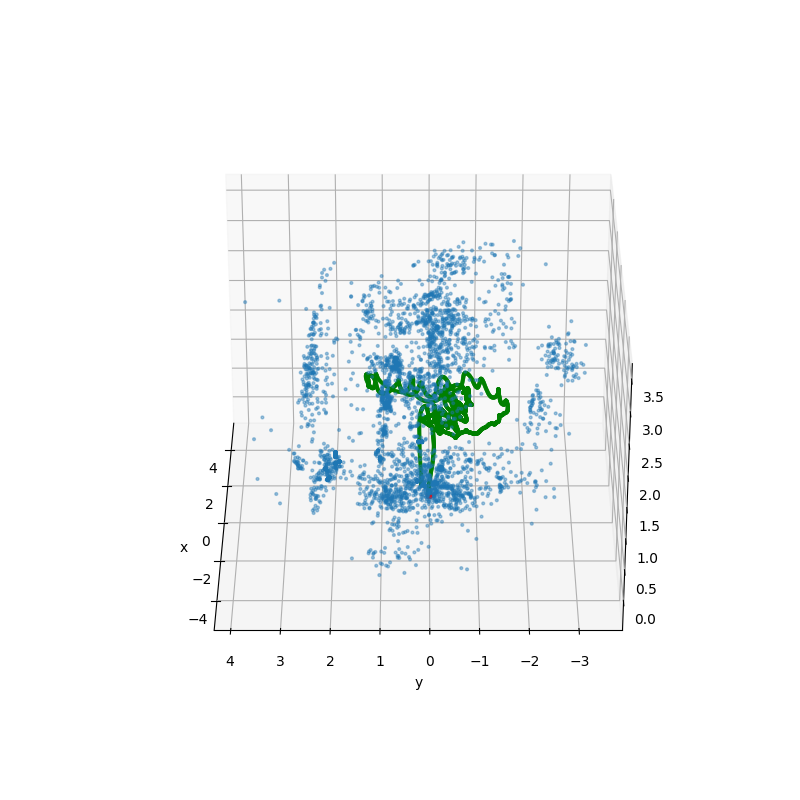

In [12]:
# plotting camera poses, looking for limits

def plot_camera_poses(tfs, ax):
    translations = np.empty((3,1))
    
    for tf in tfs:
        translations = np.append(translations, tf.t, axis = 1);
        
    ax.scatter(translations[0], 
               translations[1],
               translations[2], 
               c='g', s= 4)
    

# prepare filtering
pcl_final.compute_ranges()
pcl_filtered = copy.deepcopy(pcl_final)
pcl_out = copy.deepcopy(pcl_final)

pcl_filtered.points = np.asarray(pcl_filtered.points)
pcl_out.points = np.asarray(pcl_out.points)


max_altitude = 4.0
min_altitude = -0.2

lim_alt = np.asarray([(element[2,0] > min_altitude and element[2,0] < max_altitude)
                       
                       for element in pcl_final.points])
lim_range = np.asarray([element < 5.0 for element in pcl_filtered.ranges])

in_range = np.logical_and(lim_alt, lim_range)
in_range = in_range.reshape(len(in_range))
out_range = np.invert(in_range)

pcl_filtered.points = pcl_filtered.points[in_range]
pcl_out.points = pcl_out.points[out_range]

_, ax = plot_pointcloud(pcl_filtered, alpha = 0.4)
plot_camera_poses(tfs, ax)
plt.show()

In [14]:
# better vis
def to_o3d_pcl(pcl):
    pcd = o3d.geometry.PointCloud()
    points_reformated = np.reshape(pcl.points, (-1,3))
    pcd.points = o3d.utility.Vector3dVector(points_reformated)

    return pcd

pcd_filtered = to_o3d_pcl(pcl_filtered)
pcd_out = to_o3d_pcl(pcl_out)

pcd_full = to_o3d_pcl(pcl_final)
frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=np.array([0., 0., 0.]))

o3d.visualization.draw_geometries([pcd_filtered, frame])
#o3d.visualization.draw_geometries([pcd_out, frame])

In [15]:
pcd_processed = copy.deepcopy(pcd_full)

pcd_processed = pcd_processed.voxel_down_sample(voxel_size=0.1)

pcl, ind = pcd_processed.remove_statistical_outlier(nb_neighbors=20,
                                                    std_ratio=2.0)
o3d.visualization.draw_geometries([pcl, frame],
                                  zoom=0.7,
                                  front=[ -0.45, -0.86, 0.21],
                                  lookat=[-0.40, 2.18, 1.65],
                                  up=[0.20, 0.13, 0.96])